<a href="https://colab.research.google.com/github/limlimlim99/limjihyeonjjang/blob/main/%EC%BB%B4%ED%93%A8%ED%84%B0_%EB%B9%84%EC%A0%84.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# 케글 API 설치
!pip install kaggle --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"jihyeonlim","key":"573e7791d1cbbd69c96662fe7da02dd2"}'}

In [4]:
!mkdir ~/.kaggle  ##새로 만든 폴더
!cp kaggle.json ~/.kaggle/  ## 새로 만든 폴더를 복사하기
!chmod 600 ~/.kaggle/kaggle.json ##권한주기

In [5]:
!kaggle competitions download -c dogs-vs-cats

100% 812M/812M [00:36<00:00, 25.2MB/s]
100% 812M/812M [00:36<00:00, 23.6MB/s]


In [6]:
!unzip -qq dogs-vs-cats.zip
!unzip -qq train.zip

In [7]:
# 8-6 이미지를 훈련, 검증, 테스트 디렉터리로 복사하기
import os, shutil, pathlib

original_dir = pathlib.Path("train")  #원본데이터셋이 압축 해제되어있는 디렉터리 경로
new_base_dir = pathlib.Path("cats_vs_dogs_small") # 서브셋 데이터를 저장할 디렉터리

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" 
                  for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

make_subset("train", start_index=0, end_index=1000)  # 카테고리마다 처음 1000개의 이미지를 훈련 서브셋으로 만듦
make_subset("validation", start_index=1000, end_index=1500) # 카테고리마다 그 다음 500개의 이미지를 검증 서브셋으로 만듦
make_subset("test", start_index=1500, end_index=2500) #카테고리마다 그 다음 1000개의 이미지를 테스트 서브셋으로 만듦

In [8]:
# 모델만들기

In [9]:
# 강아지 vs 고양이 분류를 위한 소규모 컨브넷 만들기
from tensorflow import keras
from tensorflow.keras import layers

In [10]:
inputs = keras.Input(shape=(180,180,3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation='relu')(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [11]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                         

In [12]:
# 8-8 모델 훈련 설정하기
from tensorflow.python import metrics
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=['accuracy'])

In [13]:
# 데이터 전처리
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [14]:
for data_batch, labels_batch in train_dataset:
  print('데이터 배치 크기:', data_batch.shape)
  print('레이블 배치 크기:', labels_batch.shape)
  break

데이터 배치 크기: (32, 180, 180, 3)
레이블 배치 크기: (32,)


In [15]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
63/63 [==============================] - 17s 88ms/step - loss: 0.7447 - accuracy: 0.5165 - val_loss: 0.6913 - val_accuracy: 0.5820
Epoch 2/30
63/63 [==============================] - 5s 74ms/step - loss: 0.6953 - accuracy: 0.5470 - val_loss: 0.6867 - val_accuracy: 0.5550
Epoch 3/30
63/63 [==============================] - 5s 75ms/step - loss: 0.6681 - accuracy: 0.6125 - val_loss: 0.6758 - val_accuracy: 0.6070
Epoch 4/30
63/63 [==============================] - 5s 74ms/step - loss: 0.6167 - accuracy: 0.6770 - val_loss: 0.5948 - val_accuracy: 0.6850
Epoch 5/30
63/63 [==============================] - 5s 75ms/step - loss: 0.5762 - accuracy: 0.6870 - val_loss: 0.5616 - val_accuracy: 0.7250
Epoch 6/30
63/63 [==============================] - 5s 75ms/step - loss: 0.5460 - accuracy: 0.7250 - val_loss: 0.5549 - val_accuracy: 0.7130
Epoch 7/30
63/63 [==============================] - 5s 74ms/step - loss: 0.4939 - accuracy: 0.7660 - val_loss: 0.5244 - val_accuracy: 0.7450
Epoch 8/30
6

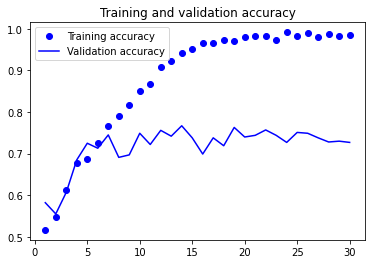

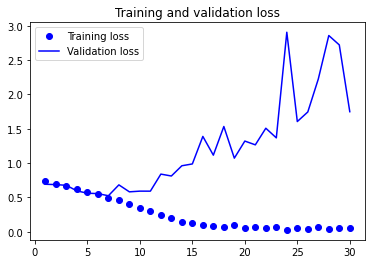

In [16]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [17]:
test_model = keras.models.load_model("convnet_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 3s 40ms/step - loss: 0.5644 - accuracy: 0.7215
Test accuracy: 0.721


In [18]:
# 컨브넷에 추가할 데이터 증식 단계 정의하기
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

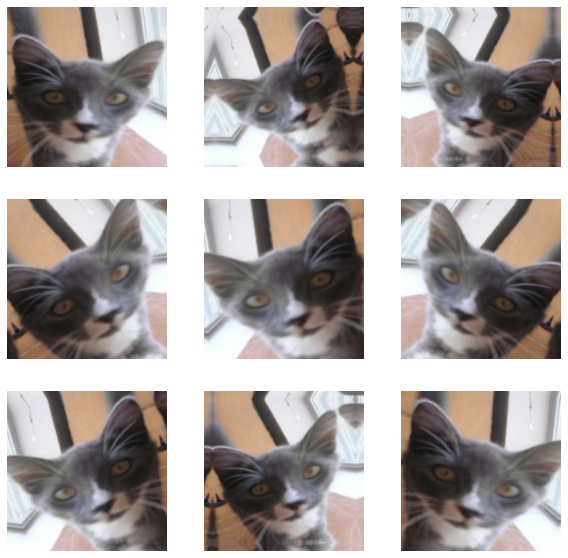

In [19]:
# 랜덤하게 증식된 훈련 이미지 출력하기
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

# 컨브넷에 추가할 데이터 증식 단계 정의

In [23]:
# 이미지 증식과 드롭아웃을 포함한 컨브넷 만들기

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)  ## 50% dropout 하겠다.
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [24]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_10 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 89, 89, 32)       0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 87, 87, 64)        18496     
                                                           

In [25]:
# 규제를 추가한 컨브넷 훈련하기
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]

history = model.fit(
    train_dataset,
    epochs=100,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/100
63/63 [==============================] - 9s 100ms/step - loss: 0.7146 - accuracy: 0.5070 - val_loss: 0.6923 - val_accuracy: 0.5000
Epoch 2/100
63/63 [==============================] - 8s 118ms/step - loss: 0.6994 - accuracy: 0.5490 - val_loss: 0.6773 - val_accuracy: 0.5470
Epoch 3/100
63/63 [==============================] - 7s 104ms/step - loss: 0.7142 - accuracy: 0.5855 - val_loss: 0.6598 - val_accuracy: 0.5750
Epoch 4/100
63/63 [==============================] - 6s 99ms/step - loss: 0.6555 - accuracy: 0.6035 - val_loss: 0.6996 - val_accuracy: 0.6060
Epoch 5/100
63/63 [==============================] - 6s 96ms/step - loss: 0.6627 - accuracy: 0.6110 - val_loss: 0.7411 - val_accuracy: 0.6270
Epoch 6/100
63/63 [==============================] - 7s 107ms/step - loss: 0.6325 - accuracy: 0.6490 - val_loss: 0.5997 - val_accuracy: 0.6730
Epoch 7/100
63/63 [==============================] - 8s 121ms/step - loss: 0.6198 - accuracy: 0.6720 - val_loss: 0.6138 - val_accuracy: 0.6680
E

In [26]:
# 테스트 세트에서 모델 훈련하기
test_model = keras.models.load_model("convnet_from_scratch_with_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 3s 38ms/step - loss: 0.4714 - accuracy: 0.8275
Test accuracy: 0.827


# 사전 훈련된 모델 활용

## 1. 사전 훈련된 모델을 사용한 특성추출

In [27]:
# VGG16 합성곱 기반 층 만들기
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

58889256/58889256 [==============================] - 3s 0us/step


In [28]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

#### 데이터 증식을 사용하지 않는 빠른 특성 추출

In [29]:
# VGG16 특성과 해당 레이블 추출하기
import numpy as np

def get_features_and_labels(dataset):
  all_features = []
  all_labels = []
  for images, labels in dataset:
    preprocessed_images = keras.applications.vgg16.preprocess_input(images)
    features = conv_base.predict(preprocessed_images)
    all_features.append(features)
    all_labels.append(labels)
  return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels = get_features_and_labels(train_dataset)
val_features, val_labels = get_features_and_labels(validation_dataset)
test_features, test_labels = get_features_and_labels(test_dataset)

1/1 [==============================] - 0s 20ms/step


In [30]:
train_features.shape

(2000, 5, 5, 512)

In [32]:
# 밀집 연결 분류기 정의하고 훈련하기
inputs = keras.Input(shape=(5, 5, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model = keras.Model(inputs, outputs)
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath='feature_extraction.keras',
        save_best_only=True,
        monitor='val_loss'
    )
]

histoty = model.fit(
    train_features, train_labels,
    epochs=20,
    validation_data=(val_features, val_labels),
    callbacks=callbacks
)

Epoch 1/20
63/63 [==============================] - 1s 11ms/step - loss: 18.7973 - accuracy: 0.9285 - val_loss: 11.6366 - val_accuracy: 0.9360
Epoch 2/20
63/63 [==============================] - 0s 7ms/step - loss: 4.5341 - accuracy: 0.9710 - val_loss: 4.1988 - val_accuracy: 0.9670
Epoch 3/20
63/63 [==============================] - 0s 8ms/step - loss: 1.9512 - accuracy: 0.9830 - val_loss: 2.7383 - val_accuracy: 0.9820
Epoch 4/20
63/63 [==============================] - 0s 7ms/step - loss: 1.6486 - accuracy: 0.9900 - val_loss: 5.9315 - val_accuracy: 0.9680
Epoch 5/20
63/63 [==============================] - 0s 7ms/step - loss: 0.4986 - accuracy: 0.9935 - val_loss: 4.4629 - val_accuracy: 0.9700
Epoch 6/20
63/63 [==============================] - 0s 6ms/step - loss: 0.4644 - accuracy: 0.9945 - val_loss: 3.1079 - val_accuracy: 0.9770
Epoch 7/20
63/63 [==============================] - 0s 6ms/step - loss: 1.0742 - accuracy: 0.9915 - val_loss: 4.2840 - val_accuracy: 0.9740
Epoch 8/20
63/63 

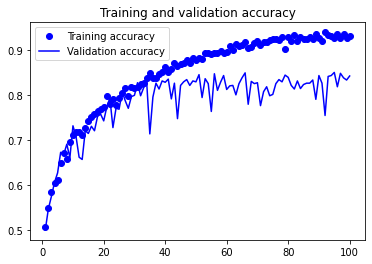

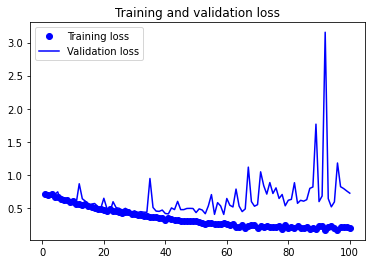

In [33]:
# 결과 그래프로 나타내기
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [34]:
test_model = keras.models.load_model('feature_extraction.keras')
test_loss, test_acc = test_model.evaluate(test_features, test_labels)
print(f'테스트 정확도: {test_acc:.3f}')

63/63 [==============================] - 0s 3ms/step - loss: 5.8300 - accuracy: 0.9685
테스트 정확도: 0.969


In [ ]:
###과제###
데이터 증식을 사용한 특성추출하기

#### 데이터 증식을 사용한 특성 추출

In [35]:
# VGG16 만들고 동결하기
## 동결하는 이유: 훈련하는 동안 가중치가 업데이트 되지 않도록 막는다.
conv_base = keras.applications.vgg16.VGG16(
    weights='imagenet',
    include_top=False
)

conv_base.trainable = False ## 동결
# False로 지정하면 층이나 모델의 훈련 가능한 가중치 리스트가 텅 비게됨

In [36]:
conv_base.trainable = True
print("합성곱 기반 층을 동결하기 전의 훈련 가능한 가중치 개수:",
      len(conv_base.trainable_weights))

합성곱 기반 층을 동결하기 전의 훈련 가능한 가중치 개수: 26


In [37]:
conv_base.trainable = False
print("합성곱 기반 층을 동결한 후의 훈련 가능한 가중치 개수:",
      len(conv_base.trainable_weights))

합성곱 기반 층을 동결한 후의 훈련 가능한 가중치 개수: 0


In [39]:
# 데이터 증식 단계와 밀집 분류기를 합성곱 기반 층에 추가하기
from keras.engine.training import optimizers
from tensorflow.python import metrics
# 데이터 증식과 밀집 분류기 추가하기
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),  ## 랜덤 뒤집기
        layers.RandomRotation(0.1),       ## 랜덤 회전
        layers.RandomZoom(0.2),           ## 랜덤 확대 또는 축소
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs) ## 데이터 증식 적용
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)  ## sigmoid는 이진 분류할때 사용
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [40]:
# 모델 훈련
callbacks = [                         ## 최상의 에포크를 찾은 모델을 저장(이로써 모델 재사용 가능)
    keras.callbacks.ModelCheckpoint(
        filepath = 'feature_extraction_with_data_augmentation.keras',
        save_best_only=True,
        monitor='val_loss'
    )
]

history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=callbacks
)

Epoch 1/50
63/63 [==============================] - 16s 229ms/step - loss: 17.2743 - accuracy: 0.9000 - val_loss: 3.7819 - val_accuracy: 0.9700
Epoch 2/50
63/63 [==============================] - 14s 220ms/step - loss: 8.2012 - accuracy: 0.9395 - val_loss: 5.5986 - val_accuracy: 0.9620
Epoch 3/50
63/63 [==============================] - 13s 211ms/step - loss: 4.9831 - accuracy: 0.9580 - val_loss: 2.7588 - val_accuracy: 0.9810
Epoch 4/50
63/63 [==============================] - 13s 202ms/step - loss: 4.6385 - accuracy: 0.9565 - val_loss: 3.4673 - val_accuracy: 0.9810
Epoch 5/50
63/63 [==============================] - 13s 201ms/step - loss: 3.6439 - accuracy: 0.9670 - val_loss: 3.8572 - val_accuracy: 0.9770
Epoch 6/50
63/63 [==============================] - 13s 211ms/step - loss: 4.3675 - accuracy: 0.9645 - val_loss: 2.6600 - val_accuracy: 0.9830
Epoch 7/50
63/63 [==============================] - 14s 212ms/step - loss: 4.6767 - accuracy: 0.9660 - val_loss: 2.9556 - val_accuracy: 0.978

In [41]:
# 테스트 세트에서 모델 훈련하기
test_model = keras.models.load_model("feature_extraction_with_data_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 8s 115ms/step - loss: 1.9723 - accuracy: 0.9770
Test accuracy: 0.977


#### 사전 훈련된 모델 미세조정하기